In [1]:
"""
Iyzico Üye İş yerlerinden Beklenilen İşlem Hacmi Tahmin

Iyzico internetten alışveriş deneyimini hem alıcılar hem de satıcılar için
kolaylaştıran bir finansal teknolojiler şirketidir. E-ticaret firmaları, pazaryerleri
ve bireysel kullanıcılar için ödeme altyapısı sağlamaktadır. 2021 yılının ilk 3
ayı için merchant_id ve gün bazında toplam işlem hacmi tahmini yapılması
beklenmekte

"""

'\nÜye iş yerlerinden beklenilen işlem hacmi tahmini\n\nIyzico internetten alışveriş deneyimini hem alıcılar hem de satıcılar için\nkolaylaştıran bir finansal teknolojiler şirketidir. E-ticaret firmaları, pazaryerleri\nve bireysel kullanıcılar için ödeme altyapısı sağlamaktadır. 2021 yılının ilk 3\nayı için merchant_id ve gün bazında toplam işlem hacmi tahmini yapılması\nbeklenmekte.\n\n'

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
warnings.filterwarnings("ignore")

In [2]:
## Veri Okuma ## 
df = pd.read_csv("iyzico_data.csv")
df = df.drop(columns=['Unnamed: 0'])
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,2018-01-01,535,349,25883.226
1,2018-01-01,42616,141,40918.860
2,2018-01-01,46774,410,306902.700
3,2018-01-01,86302,10,11.340
4,2018-01-01,124381,285,111383.766


In [3]:
## Transaction_date değişkeninin tipini date'e çevirdik
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

## Veri setinin başlangıç ve bitiş tarihlerine baktık.
df['transaction_date'].min(), df['transaction_date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [4]:
## Veriye genel bir bakış
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(7667, 4)
##################### Types #####################
transaction_date     datetime64[ns]
merchant_id                   int64
Total_Transaction             int64
Total_Paid                  float64
dtype: object
##################### Head #####################
  transaction_date  merchant_id  Total_Transaction  Total_Paid
0       2018-01-01          535                349   25883.226
1       2018-01-01        42616                141   40918.860
2       2018-01-01        46774                410  306902.700
3       2018-01-01        86302                 10      11.340
4       2018-01-01       124381                285  111383.766
##################### Tail #####################
     transaction_date  merchant_id  Total_Transaction   Total_Paid
7662       2020-12-31        46774               3394  3174751.332
7663       2020-12-31        57192                856   337696.020
7664       2020-12-31        86302               2657  

In [5]:
df["merchant_id"].unique()

array([   535,  42616,  46774,  86302, 124381, 129316,  57192],
      dtype=int64)

In [7]:
## Her üye iş yerindeki toplam işlem sayısı
df.groupby(["merchant_id"]).agg({"Total_Transaction": ["sum"]})

,Total_Transaction
,sum
merchant_id,
535.0,1302725.0
42616.0,1126191.0
46774.0,1599559.0
57192.0,1146440.0
86302.0,840951.0
124381.0,1935357.0
129316.0,440029.0


In [6]:
## Her üye iş yerindeki toplam ödeme miktarı
df.groupby("merchant_id").agg({"Total_Paid":"sum"})

,Total_Paid
merchant_id,
535,1.566015e+08
42616,3.545831e+08
46774,1.567200e+09
57192,3.173371e+08
86302,2.870447e+06
124381,1.158693e+09
129316,1.555471e+06


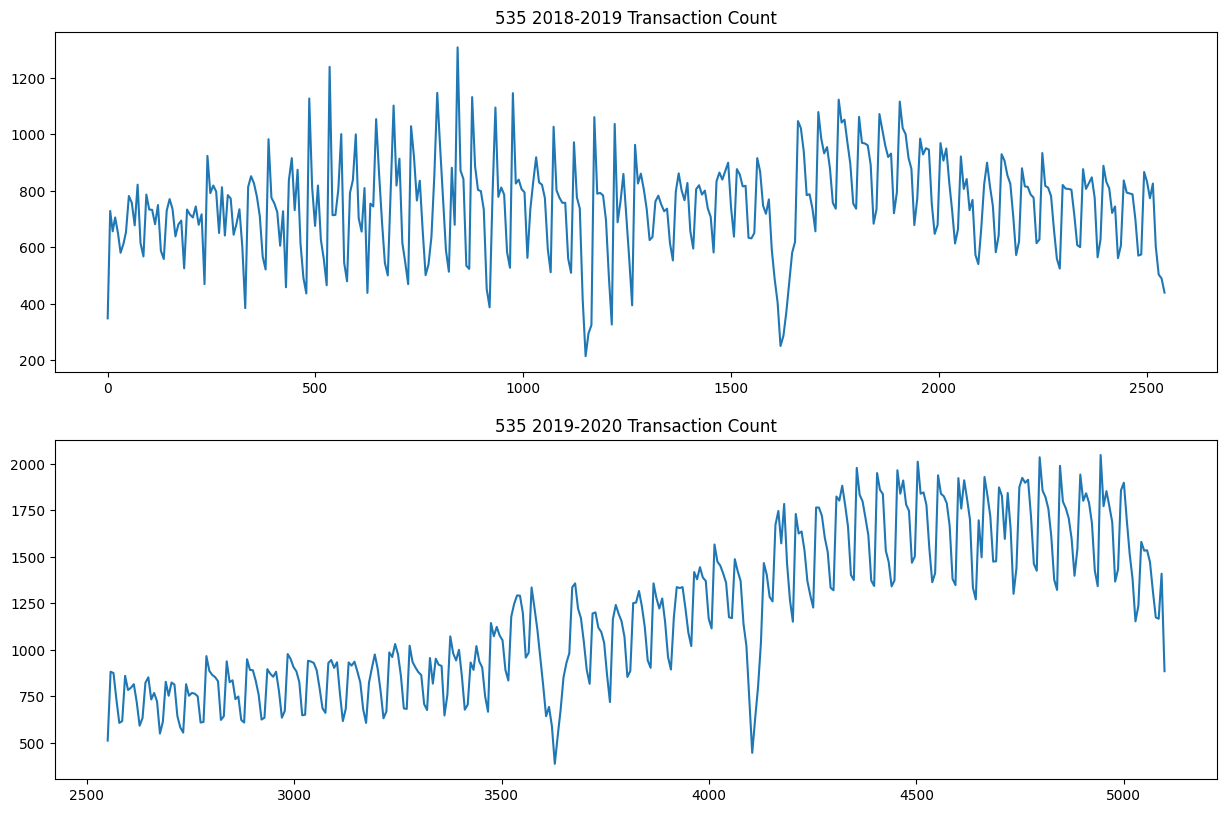

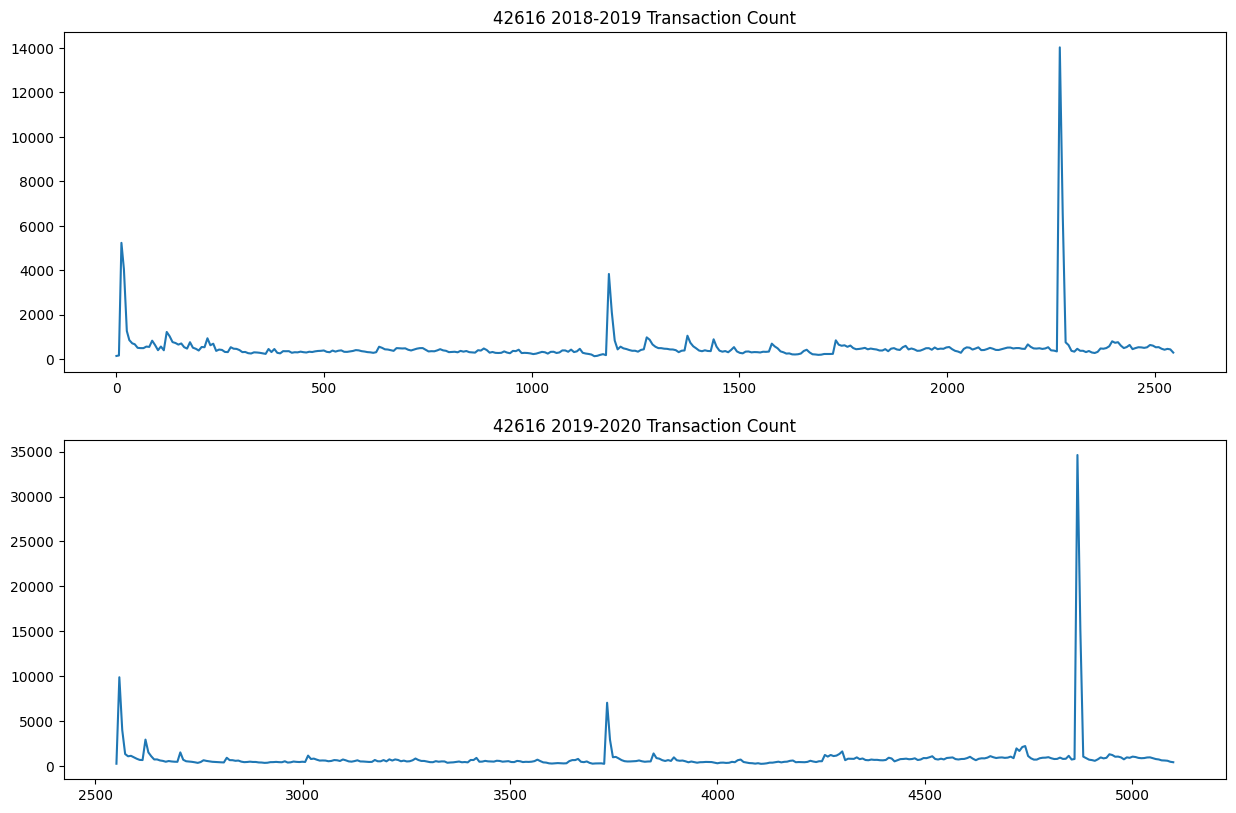

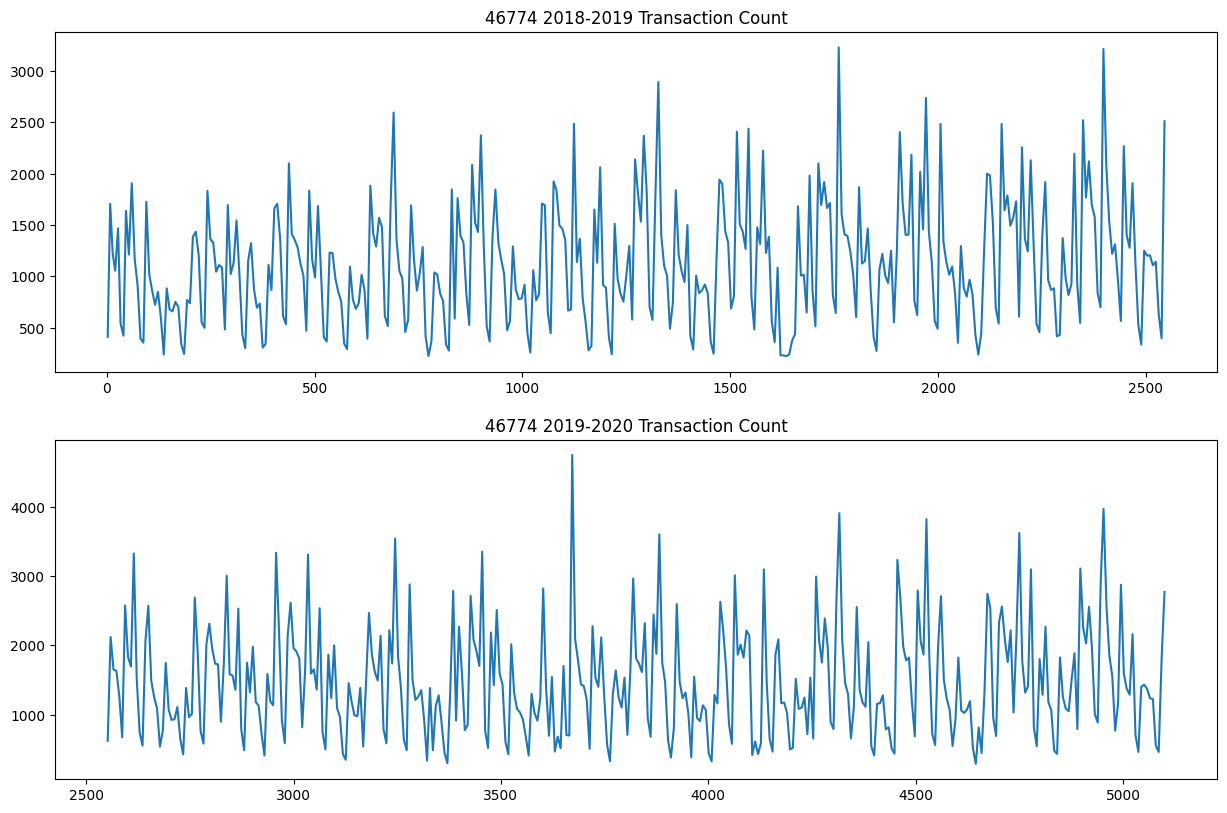

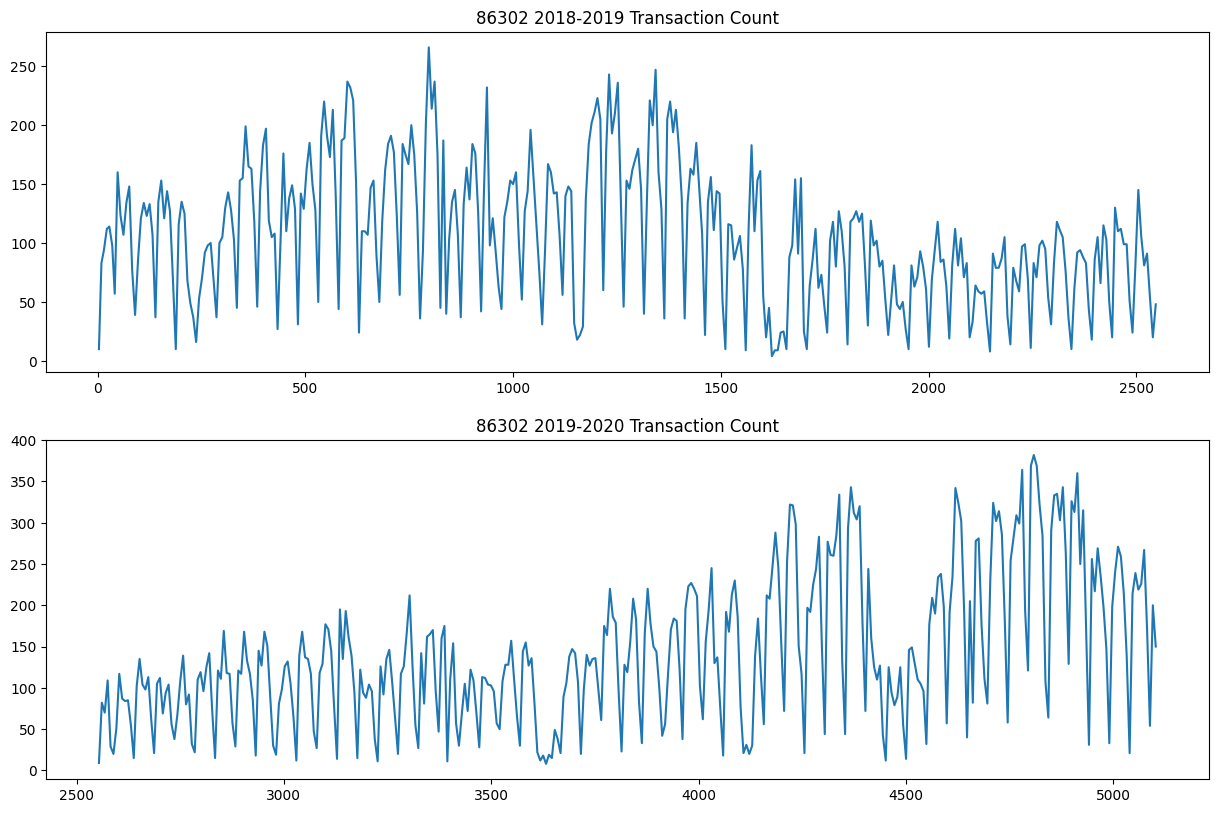

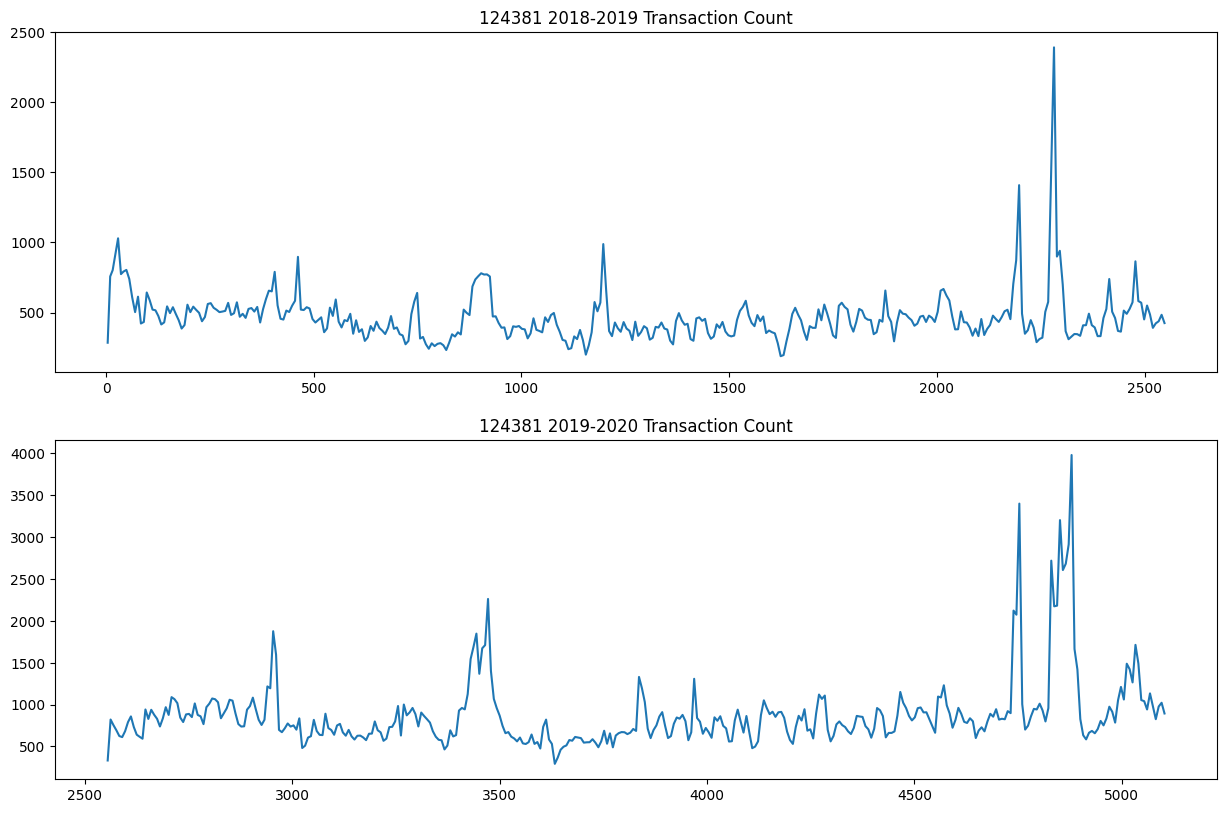

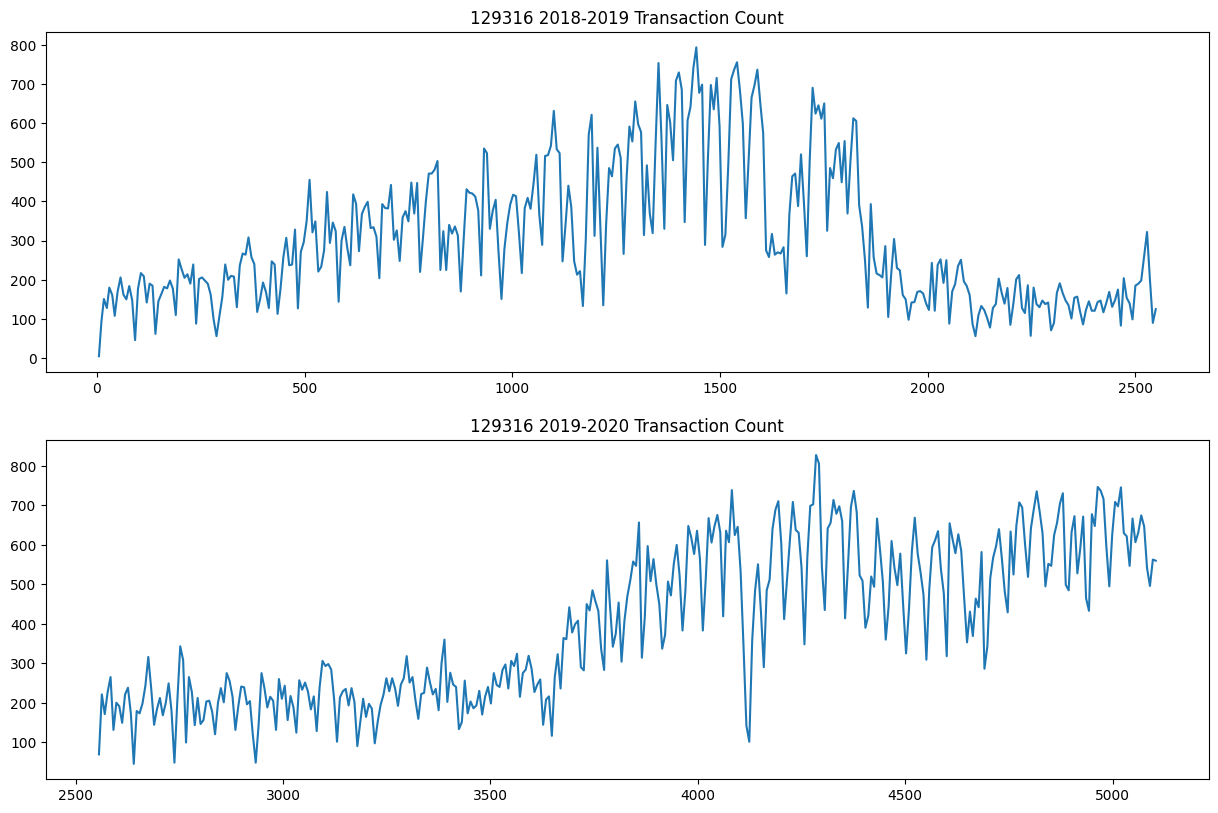

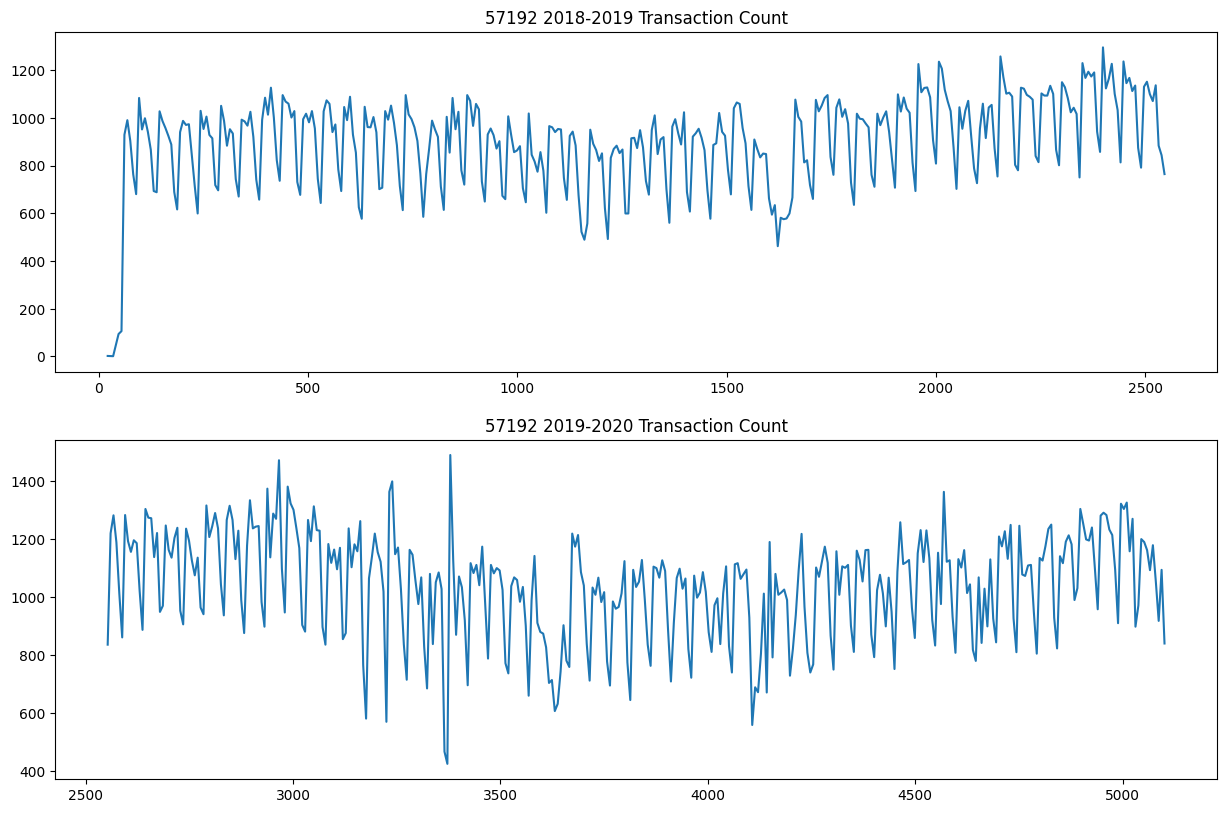

In [8]:
for id in df.merchant_id.unique():
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 1, 1, title = str(id) + ' 2018-2019 Transaction Count')
    df[(df.merchant_id == id) & ( df.transaction_date >= "2018-01-01" ) & (df.transaction_date < "2019-01-01")]["Total_Transaction"].plot()
    plt.xlabel('')
    plt.subplot(3, 1, 2,title = str(id) + ' 2019-2020 Transaction Count')
    df[(df.merchant_id == id) &( df.transaction_date >= "2019-01-01" )& (df.transaction_date < "2020-01-01")]["Total_Transaction"].plot()
    plt.xlabel('')
    plt.show()

In [9]:
## FEATURE ENGINEERING ###

# Mevsimsellik alanında feature'lar ürettik
def create_date_features(df):
    df['month'] = df.transaction_date.dt.month
    df['day_of_month'] = df.transaction_date.dt.day
    df['day_of_year'] = df.transaction_date.dt.dayofyear
    df['week_of_year'] = df['transaction_date'].apply(lambda x: x.isocalendar()[1])
    df['day_of_week'] = df.transaction_date.dt.dayofweek
    df['year'] = df.transaction_date.dt.year
    df['is_wknd'] = df.transaction_date.dt.weekday // 4
    df['is_month_start'] = df.transaction_date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.transaction_date.dt.is_month_end.astype(int)
    df['quarter'] = df.transaction_date.dt.quarter
    df['is_quarter_start'] = df.transaction_date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.transaction_date.dt.is_quarter_end.astype(int)
    df['is_year_start'] = df.transaction_date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.transaction_date.dt.is_year_end.astype(int)
    return df

create_date_features(df)
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2018-01-01,535,349,25883.226,2018,1,1,1,1,0,0,1,0,1,1,0,1,0
1,2018-01-01,42616,141,40918.860,2018,1,1,1,1,0,0,1,0,1,1,0,1,0
2,2018-01-01,46774,410,306902.700,2018,1,1,1,1,0,0,1,0,1,1,0,1,0
3,2018-01-01,86302,10,11.340,2018,1,1,1,1,0,0,1,0,1,1,0,1,0
4,2018-01-01,124381,285,111383.766,2018,1,1,1,1,0,0,1,0,1,1,0,1,0


In [10]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])

In [11]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby("merchant_id")['Total_Transaction']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

df = roll_mean_features(df, [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])

In [12]:
# Üstel ağırlıklı hareketli ortalama özellikleri oluşturma fonksiyonu
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby("merchant_id")['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)
df.head()
df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_a

In [13]:
########################
# Black Friday - Summer Solstice
########################

df["is_black_friday"] = 0
df.loc[df["transaction_date"].isin(["2018-11-22","2018-11-23","2019-11-29","2019-11-30"]) ,"is_black_friday"]=1

df["is_summer_solstice"] = 0
df.loc[df["transaction_date"].isin(["2018-06-19","2018-06-20","2018-06-21","2018-06-22",
                                    "2019-06-19","2019-06-20","2019-06-21","2019-06-22",]) ,"is_summer_solstice"]=1

In [14]:
## One-Hot Encoding ##
df = pd.get_dummies(df, columns=['merchant_id','day_of_week', 'month'])
## Bağımlı Değişkenin Logaritması ( Log of Dependent Variable ) ##
df['Total_Transaction'] = np.log1p(df["Total_Transaction"].values)

In [15]:
########################
# Custom Cost Function
########################

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)


def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [16]:
########################
# Time-Based Validation Sets
########################

import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# 2020'nin 10.ayına kadar train seti.
train = df.loc[(df["transaction_date"] < "2020-10-01"), :]

# 2020'nin son 3 ayı validasyon seti.
val = df.loc[(df["transaction_date"] >= "2020-10-01"), :]

cols = [col for col in train.columns if col not in ['transaction_date', 'id', "Total_Transaction","Total_Paid", "year" ]]

Y_train = train['Total_Transaction']
X_train = train[cols]

Y_val = val['Total_Transaction']
X_val = val[cols]

# kontrol
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 212), (644,), (644, 212))

In [19]:
########################
# LightGBM Model
########################

# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}


lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(
    lgb_params, 
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=lgb_params['num_boost_round'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=100)  # This replaces verbose_eval
    ],
    feval=lgbm_smape
)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.297004	training's SMAPE: 28.4702	valid_1's l1: 0.286663	valid_1's SMAPE: 27.39
[200]	training's l1: 0.243421	training's SMAPE: 23.5495	valid_1's l1: 0.226037	valid_1's SMAPE: 21.799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's l1: 0.221932	training's SMAPE: 21.5571	valid_1's l1: 0.212843	valid_1's SMAPE: 20.6035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

20.49194326885256

In [21]:
y_pred_val = model.predict(X_val, num_iteration = model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

20.49194326885256

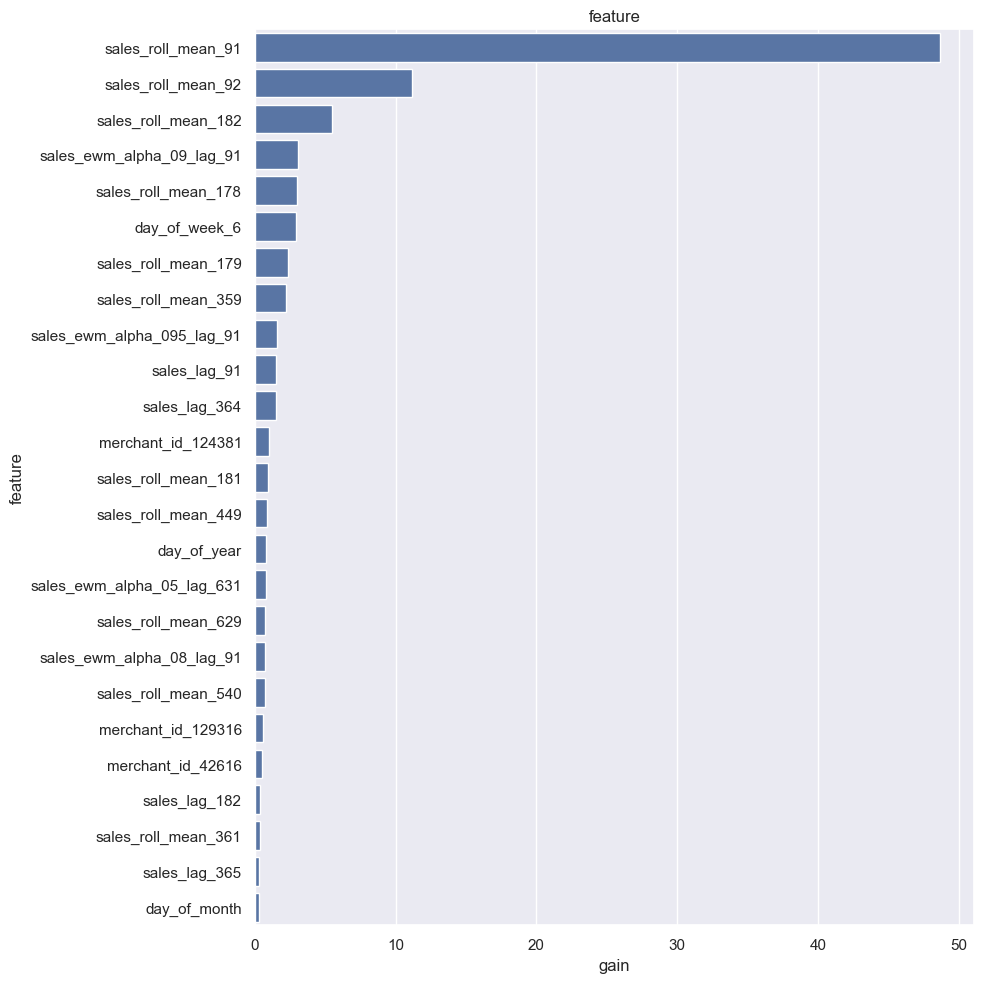

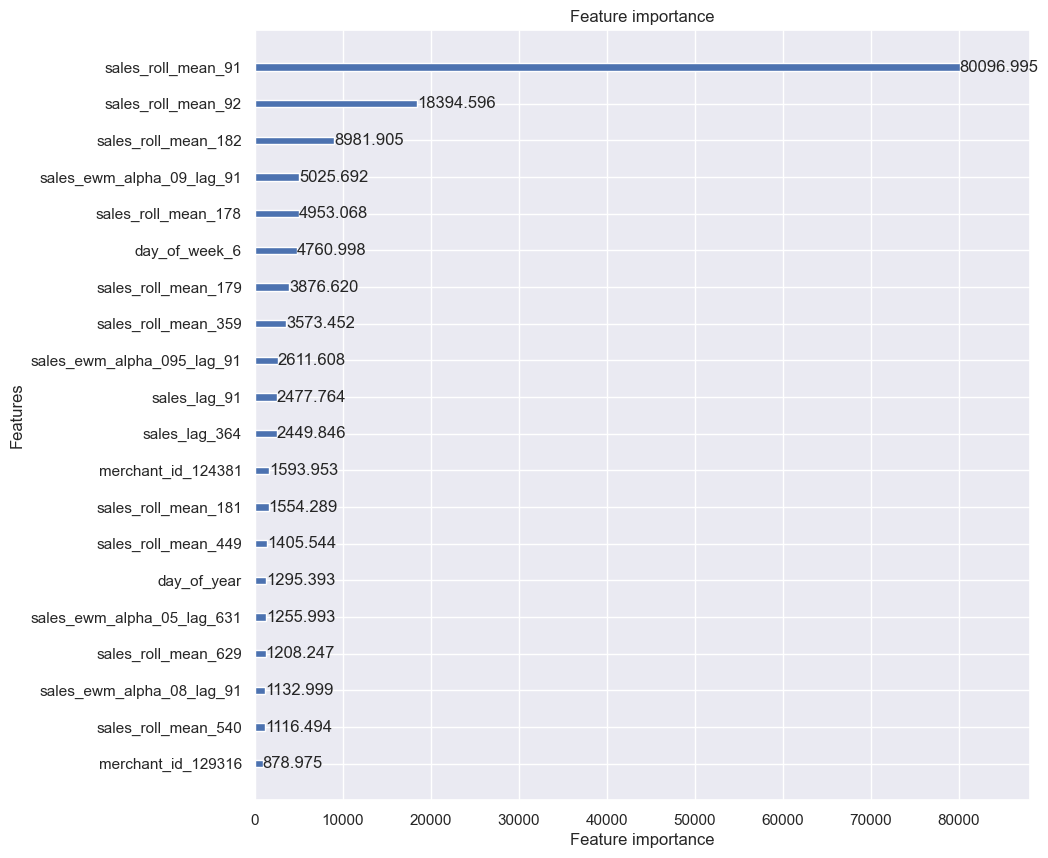

In [20]:
########################
# Feature Importance
########################

def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()